In [0]:
# Imports first

import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Final Assignment
### INFO 5502
### Maia Petee
---


December 6th, 2019


1. Read chapter 11 and choose an example to explain how to test hypothesis. You need describe a problem, define null hypothesis and alternative hypothesis, and then define test statistic. Check the distribution of the Test Statistic under the Null hypothesis, and finally make conclusion of the test. You must describe each step using example. 



---
Testing a hypothesis almost always involves posing an initial yes or no question about some aspect of the world. For example, we might ask ourselves whether a certain food is good or bad for us, whether high stress levels are related to an early death, or whether a medication really does work. We could ask any question for which sufficient data is available (or able to be gathered). After data is collected and an EDA is conducted on that data, we can decide whether the data is sufficient to test the hypothesis. 

An important part of testing hypotheses is defining the **null** and **alternative** hypotheses for a given question. For example, if testing whether stress leads to an early death, the null hypothesis would assume that there is no (provable) relationship, and that there is no reason to believe that stress does lead to an early death, and the alternative hypothesis would assert that stress does lead to an early death. The goal of the tests would be to determine which of these hypotheses the data empirically supports.

To illustrate using an example, I'll use the example given in the text, regarding the racial makeup of jury selection in the 1960s Supreme Court.The problem was that, in the rape trial of a black man in which he was sentenced to death, an unusually small number of the potential jurors were black themselves (even when the makeup of the population was taken into account) - 8 out of 100 in the selection pool, and 0 out of 12 in the final jury.

Swain's appeal claimed that this was racial profiling, and that the jury selection and makeup were not likely to occur under random chance with the available population. 

* Null hypothesis: The number of black men in the jury was a possible outcome given random chance.
* Alternative hypothesis: The number of black men in the jury was **not** likely given random chance.
* Test Statistic (i.e. how to test): the number of black men in repeated simulated samples taken truly at random from the population (26% black).

Below we will show how to simulate ONE sample.

In [40]:
# DataScience has a great method for this when the sample is not evenly distributed among
# one or more groups: it's sample_proportions().

eligible_population = [0.26, 0.74]      # The two numbers in this array represent the number of black men and the number of white men in the population, respectively.
print("There are",np.round((100 * sample_proportions(100, eligible_population)).item(0), 0),"black men in this sample of 100") # Running sample_proportions on this distribution will give us the proportion of black jurors and white jurors in a single sample.
 

There are 20.0 black men in this sample of 100


But we need to do this many times to get an idea of how frequently we might expect each of these racial distributions under random chance.

In [0]:
# Making the code in a previous cell into a function.
def one_simulated_count():
    return (100 * sample_proportions(100, eligible_population)).item(0)

# Creating an empty array to store many simulated samples.
counts = make_array()

# Defining the number of samples to run, running them, and adding them to the array
repetitions = 10000
for i in np.arange(repetitions):
    counts = np.append(counts, one_simulated_count())


After running ten thousand simulations of how many black men would be in a randomly chosen sample of 100 potential jurors, we can create a histogram 
that shows the distribution of all 10000 simulations. Any jury distribution the racial distribution of which falls within the body of the bell-shaped distribution below is likely to be a jury pool distribution that is possible under random chance, but looking at where the ACTUAL jury distribution, represented by a red dot, falls, we can safely assume that it was NOT random chance that led to this jury selection. Racial bias seems very likely. Maybe if the jury pool contained 18 black men out of 100 (along the x-axis, 18 seems to fall within a 95% confidence interval, which would indicate the numerical range of black men per 100 jurors that samples would fall within 95% of the time), the prosecution would have more of a leg to stand on with their assertion that random chance was involved, but as it is, their assertion seems very unlikely.

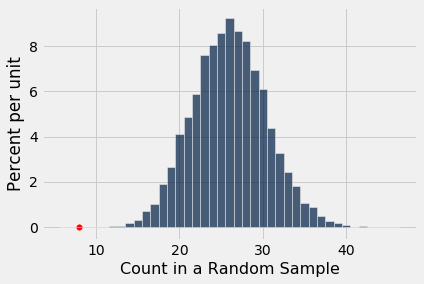

In [42]:
Table().with_column(
    'Count in a Random Sample', counts
).hist(bins = np.arange(5.5, 46.6, 1))
plt.scatter(8, 0, color='red', s=30);

Given the results of the simulation above, it seems valid to **reject the null hypothesis and accept the alternative hypothesis**. This means that we reject the assertion that the jury members were chosen via random chance and embrace the assertion that selection was not random. Note that we do not want to go further and say that the lack of randomness was DEFINITELY due to race, even though this is the most obvious social reality and we intuit that this is the case; empirically, all we can say is that selection was not random.



---

2. A/B Testing: Use an example to explain A/B testing. 

A/B Testing is a way to compare two random samples to each other, rather than to an unspecified "randomly chosen sample" from the population. This experiment design is of great use when comparing a treatment group to a control group (an extremely common design in pharmaceutical or other treatment trials, or perhaps in educational trials where an experimental classroom approach is being tested against a more established approach); the name comes from the fact that we are looking at a sample "A" and comparing it to another sample "B". 

To illustrate a process of comparing two samples to each other, I'll use an example from the text that looks at the birth weight of newborns and whether their mothers smoked during pregnancy. In this example, sample "A" would be a group of newborns whose mothers smoked during pregnancy, and sample "B" would be an otherwise similar group of newborns whose mothers did not smoke during pregnancy (when comparing A to B, it is necessary to make sure that the two samples are as alike as possible in all other ways than the independent variable. This helps to eliminate confounding variables). 

In [43]:
births = Table.read_table('baby.csv') # Reading in the full table of neonatal data
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight') # Selecting only the independent and dependent variables for this sampling - Smoking(True/False) and Birth Weight
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


To begin to visualize a possible difference between these two samples, we can create an overlaid histogram showing a distribution of birth weights of smoking mothers vs. those of non-smoking mothers.

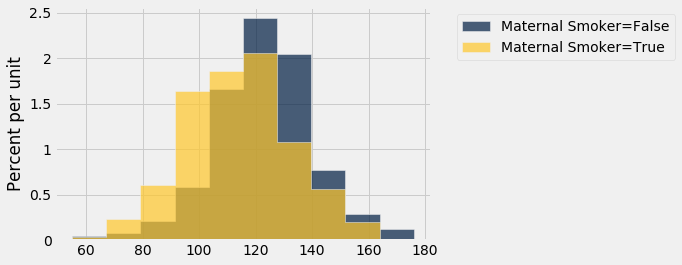

In [44]:
smoking_and_birthweight.hist('Birth Weight', group = 'Maternal Smoker')

There does seem to be a visibly perceptible difference - birth weights for mothers who smoke during pregnancy seem to be shifted slightly to the left (i.e. lower birth weights overall) from those of nonsmoking mothers. This briefest of EDAs, which illustrates visually that a relationship is likely present, indicates that we can proceed with comparing these two samples, to see if we can formalize this relationship.

We will use the concepts of null and alternative hypothesis, as well as a well-chosen test statistic, to formalize this test as well. In this case:

**null hypothesis**: There is no statistical difference between these two samples (birth weights of babies born to non-smoking mothers and birth weights of babies born to smoking mothers). 
**alternative hypothesis**: Birth weights of smoking mothers are (on average) lower than birth weights of non-smoking mothers.

Since the alternative hypothesis differs from the null on the basis of average birth weight, the **test statistic** can be the difference in average birth rate between the two groups.

In [45]:
# Finding the OBSERVED test statistic.

means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

Since the observed difference between the two groups is -9.26, we can run a simulation to yield a distribution and a fair 95% confidence interval of what this observed difference - the difference of the means of the two groups - might be given random chance. To accomplish this, we will reshuffle the maternal labels, but not the baby weights, of the table, effectively pretending that the observed baby weights could randomly have been produced by either a smoking or a non-smoking mother.

In [46]:
# Creating a function that finds the test statistic one time.

def difference_of_means(table, label, group_label):
    reduced = table.select(label, group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)

def one_simulated_difference(table, label, group_label):
    shuffled_labels = table.sample(with_replacement = False
                                                    ).column(group_label)
    shuffled_table = table.select(label).with_column(
        'Shuffled Label', shuffled_labels)
    return difference_of_means(shuffled_table, label, 'Shuffled Label') 

one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

-1.7682252388134856

In [0]:
# Simulating that statistic 5000 times and visualizing the results

differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences = np.append(differences, new_difference)      

Observed Difference: -9.266142572024918


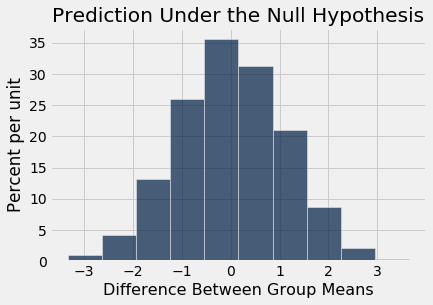

In [48]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plt.title('Prediction Under the Null Hypothesis');

Remember, since the observed statistic is -9.26, and is thus not even on the graph of test statistic possibilities under the null hypothesis, we are pretty safe in saying that the null hypothesis can be rejected and the alternative - that maternal smoking does lead to lower birth weights - can be accepted.


---

3. The Bootstrap: Explain the purposes and the steps of bootstrap using an example.

Bootstrapping is a very useful tool in statistical estimation, especially when many resamples are needed, as they usually are in data science (because a good data scientist doesn't allow themselves to use a test statistic taken from one random sample as a statistical estimate of the parameter), and when those resamples for some reason (whether the population is unavailable, or the original sample WAS the population) cannot be gathered as normal from the population. **Bootstrapping is a method that samples from an existing sample instead of the population. It needs to be done with replacement, so that the resamples aren't just carbon copies of the original sample.**

To demonstrate an example of bootstrapping, I'll use the example from the text that looks at a sample of employee salaries for the city of San Francisco in the year 2015.

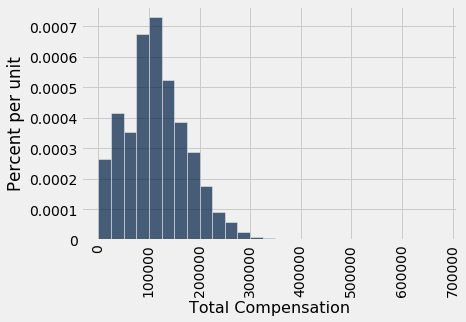

In [49]:
# Loading a table of population data and excluding outliers

sf2015 = Table.read_table('san_francisco_2015.csv')
sf2015 = sf2015.where('Salaries', are.above(10000))

# Viewing the population as a histogram 

sf_bins = np.arange(0, 700000, 25000)
sf2015.select('Total Compensation').hist(bins=sf_bins)

The test statistic in this example will be the median salary. In this dataset, while we know the population median (calculated below), the goal of this example will be to bootstrap many samples from a **single sample of the population** and see if we can arrive at an empirical estimate of the median that reflects reality.

In [50]:
# Calculating the population median - the statistic that we will replicate using the bootstrap

pop_median = percentile(50, sf2015.column('Total Compensation'))
pop_median

110305.79

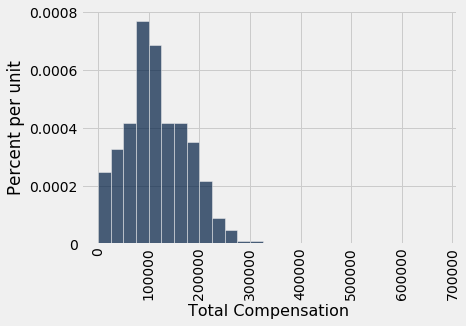

In [51]:
# Taking a sample of 500 from the population of close to 37,000

our_sample = sf2015.sample(500, with_replacement=False)
our_sample.select('Total Compensation').hist(bins=sf_bins)

The histogram of the sample shows a very similar shape to the distribution of the population; it still seems unlikely to say that we can arrive at a good estimate of the population median using only this one sample, however! 

The sample median is not far from the population median (about $2,000 off - see below):

In [52]:
# Calculating the sample median

est_median = percentile(50, our_sample.column('Total Compensation'))
est_median

109303.64

The function below will perform 5000 resamples of the population sample, and add the median of each of those resamples to an array that can be used as an empirical distribution of our estimate of the median.

In [0]:
def bootstrap_median(original_sample, label, replications):
    """Returns an array of bootstrapped sample medians:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    """
    just_one_column = original_sample.select(label)
    medians = make_array()
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resampled_median = percentile(50, bootstrap_sample.column(0))
        medians = np.append(medians, resampled_median)
        
    return medians

bstrap_medians = bootstrap_median(our_sample, 'Total Compensation', 5000)

In [0]:
# Calculating a 95% confidence interval of the test statistic

left = percentile(2.5, bstrap_medians)
right = percentile(97.5, bstrap_medians)

Now, we can graph these bootstrapped medians and see where the population median falls on this distribution. It seems as though our bootstrapped medians, using just one original sample of the population, were together able to form a distribution that reflects and contains the original population median. The graph below shows a 95% confidence interval of the estimated test statistic (bootstrapped medians) in yellow, as well as the observed test statistic as a red dot.

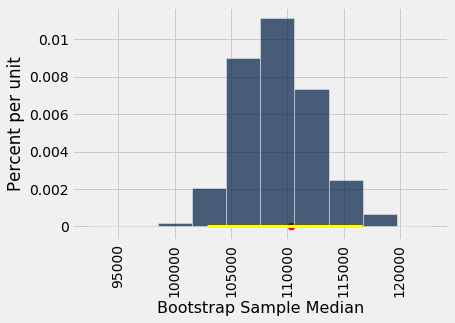

In [55]:
resampled_medians = Table().with_column('Bootstrap Sample Median', bstrap_medians)
resampled_medians.hist()
plt.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=3, zorder=1)
plt.scatter(pop_median, 0, color='red', s=50);

Bootstrapping is an invaluable tool for data scientists, since in many real-world scenarios, population statistics are simply not available, whether due to lack of resources to sample them, or lack of access to the entire population. Bootstrapping allows us to draw conclusions about populations with reasonable confidence using only one representative sample (although it creates many estimates using this one sample, to avoid the bias or variability that might be present in the sample), which is a phenomenal accomplishment.


---
4. Confidence Intervals: Explain what is Confidence Interval and how to check the Confidence Level. 

The concept of the confidence interval is related to all the topics we've already discussed. In the previous bootstrapping example, we created a 95% confidence interval for the estimate of the population median. What this means is that 95% of the time, or 95 times out of 100, we have confidence that the population parameter will fall within this range (which was arrived at through bootstrapping sample medians).

A common way of getting this interval is through percentiles of a large random sample. The median (50th percentile - the point at which 50% of the data points are lower and 50% are higher) of the distribution is so valuable to data scientists because it is unaffected by outliers, unlike the mean; thus, confidence intervals, which are also based on percentiles, are similarly robust against the numerical forces of outliers. 

A confidence interval is situated at the middle of a distribution of estimates; for example, a 95th confidence interval will begin at the 2.5th percentile and extend to the 97.5% percentile. Similarly, an 80% confidence interval will start at the 10th percentile and extend to the 90th.

A confidence interval can be taken of any test statistic that has been decided upon as a good measure for a certain empirical test; means can also be used for this measure. The book demonstrates this method through a bootstrap percentile method, in which the test statistic of a large random sample (in this case, of maternal age at birth) is bootstrapped and therefore estimated.

The table of baby birth weights also includes the age of the mothers at the baby's birth; since the available data does not encompass all babies or all mothers (even those born at this particular hospital), we will treat the table as a large random sample of the population of all babies and all mothers.

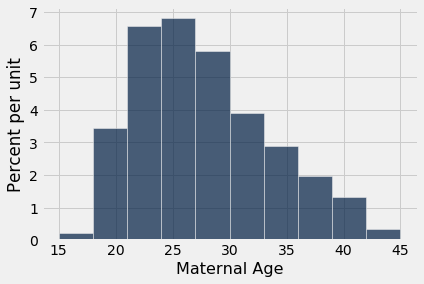

In [57]:
births.select('Maternal Age').hist()

In [58]:
np.mean(births.column('Maternal Age'))

27.228279386712096

The observed mean - the mean of this large random sample of maternal ages - is about 27 years and three months. We don't know the average maternal age in the population, since that data is not available to us, but we can estimate it via a bootstrapped percentile calculation similar to that in the previous question.

In [59]:
# Creating a function to calculate a certain number of bootstrapped means from an array of numbers

def bootstrap_mean(original_sample, label, replications):
    
    """Returns an array of bootstrapped sample means:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    """
    
    just_one_column = original_sample.select(label)
    means = make_array()
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resampled_mean = np.mean(bootstrap_sample.column(0))
        means = np.append(means, resampled_mean)
        
    return means

# Running this function 5,000 times

bstrap_means = bootstrap_mean(births, 'Maternal Age', 5000)

# Getting the endpoints of the 95% confidence interval

left = percentile(2.5, bstrap_means)
right = percentile(97.5, bstrap_means)

make_array(left, right)

array([26.90459966, 27.55110733])

The array above, which is our 95% confidence interval, states that we can say with about 95% certainty that the mean age of mothers in the population is between 26.9 years and 27.6 years. This seems to be a fairly precise estimate that is clustered closely to the random sample estimate of 27.2 years, only varying by .7 years in total. 

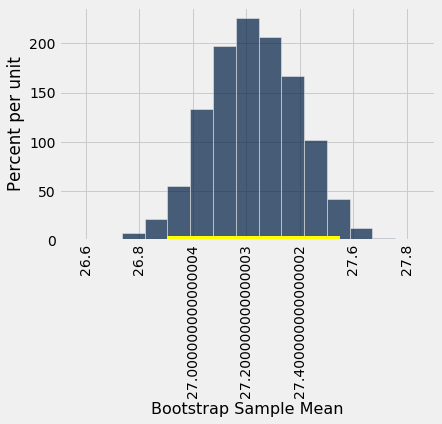

In [60]:
resampled_means = Table().with_column(
    'Bootstrap Sample Mean', bstrap_means
)
resampled_means.hist(bins=15)
plt.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);

The point is that a confidence interval of any test statistic x and any percentile(s) y can be calculated via this method; resampling and bootstrapping from a sample a large number of times, and then taking an interval of the statistic using percentiles across these bootstrapped iterations.


---
5. Loss Functions and Gradient Descent: Explain what is Loss Function, and how to use Gradient Descent to minimizing loss function (use an example loss function, and write and explain the python code that implement the gradient descent analysis for minimizing loss function).

In conducting a linear regression, a line that best "fits" a scatterplot of observed data, the predicted line will inevitably result in some amount of loss, meaning that for each point x, the predicted point y will differ from the observed point y by some amount. This difference is the loss for each point. A closely related concept is that of theta, which represents the best *mean* predicted value for the dependent variable under consideration. "Best," here, means the mean predicted value that minimizes loss across the entire regression. 

There are a number of methods for measuring loss, and therefore calculating the minimum possible loss for a regression. The simplest of these to calculate is MSE, or mean squared error. This calculation measures each predicted value against a value of theta, takes the difference, squares that difference, and finally takes the mean value of all those squared differences. The goal of the loss function is to minimize this mean squared error, so a number of theta values will be tried to see which produces the lowest value of the loss function. A good way of streamlining this process is to graph loss for a number of values of theta, and see where loss is at its lowest (the distribution will resemble a parabola). In the end, however, mean squared error is in fact an extremely easy calculation: just take the mean of all the data points of the dependent variable. 

Automating the minimum loss calculation is more complex. Most methods of calculating loss require manually setting values of theta, and moving closer to the value that successfully minimizes loss based on feedback. 

A way around this inefficient manual process is by using **gradient descent**, which is a function that looks at the slope of a loss distribution at a certain initial theta and readjusts its estimate of theta repeatedly until the slope of the distribution at a certain theta is close to or at zero. This is the theta value at which loss is minimized. 

A gradient descent function, when encountering a negative slope at a particular theta, knows that the value of theta needs to be increased, and repeats the calculation for a new, increased value of theta. Then, depending on the slope (negative = increase theta, positive = decrease theta), the value of theta will be adjusted and a new calculation repeated, etc. 

Below, a function that starts theta at 0 and then adjusts the value of theta incrementally based on the slope of the distribution at the point theta is created.


In [0]:
def minimize(loss_fn, grad_loss_fn, dataset, alpha=0.2, progress=True):
    '''
    Uses gradient descent to minimize any loss function. Returns the minimizing value of
    theta_hat once theta_hat changes less than 0.001 between iterations.
    '''
    theta = 0
    while True:
        if progress:
            print(f'theta: {theta:.2f} | loss: {loss_fn(theta, dataset):.2f}')
        gradient = grad_loss_fn(theta, dataset)
        new_theta = theta - alpha * gradient
        
        if abs(new_theta - theta) < 0.001:
            return new_theta
        
        theta = new_theta

In [0]:
# Defining MSE and gradient MSE

def mse(theta, y_vals):
    return np.mean((y_vals - theta) ** 2)

def grad_mse(theta, y_vals):
    return -2 * np.mean(y_vals - theta)

Below, the gradient descent process can be seen in action with an array of 5 numbers. For each iteration of theta, loss is calculated. Initially, theta is 0 and MSE loss is 218; next, theta is 5.86 and loss is 81.21, and so on. Since we know that the mean of the target array is 14.66, we know that 0 is far too small a value of theta and that theta in the next iteration must be larger. 

Another interesting thing to note is that the jumps in theta between each iteration are initially quite large, and that as loss approaches its minimum (and the derivative keeps getting closer to 0), changes are much smaller. The last several iterations are based on only tiny changes of one one hundredth or less; finally, when the minimization of loss gained by another iteration of the function is less than 1/1000, the function declares the current iteration of theta as the "true" theta.

In [71]:
# Running the minimize function for the MSE method of calcuation

theta = minimize(mse, grad_mse, np.array([12.1, 12.8, 14.9, 16.3, 17.2]))
print(f'Minimizing theta: {theta}')
print()

theta: 0.00 | loss: 218.76
theta: 5.86 | loss: 81.21
theta: 9.38 | loss: 31.70
theta: 11.49 | loss: 13.87
theta: 12.76 | loss: 7.45
theta: 13.52 | loss: 5.14
theta: 13.98 | loss: 4.31
theta: 14.25 | loss: 4.01
theta: 14.41 | loss: 3.90
theta: 14.51 | loss: 3.86
theta: 14.57 | loss: 3.85
theta: 14.61 | loss: 3.85
theta: 14.63 | loss: 3.84
theta: 14.64 | loss: 3.84
theta: 14.65 | loss: 3.84
theta: 14.65 | loss: 3.84
theta: 14.66 | loss: 3.84
theta: 14.66 | loss: 3.84
Minimizing theta: 14.658511131035242



In [64]:
# Since MSE is such a simple calculation, we can check our results by taking the mean of the target array:

np.mean([12.1, 12.8, 14.9, 16.3, 17.2])

14.66

Gradient descent is especially valuable for calculations that are less simple to estimate analytically, such as the more complicated Huber Loss function, which has the advantage of being less sensitive to outliers in data.